In [1]:
import numpy as np
import mpmath 
import matplotlib.pyplot as plt
import math as mth
from scipy import linalg, signal, constants, optimize, signal

In [2]:
with open('rho_1dots_dt5e-5_fixed.dat') as file:
    rho_00_Elliot = []
    for index,line in enumerate(file):
        values = line.split(' ')
        rho_00_Elliot.append(np.float(values[0]))
rho_00_Elliot = np.array(rho_00_Elliot)

In [3]:
with open('chi_fix.dat') as file:
    chi_Elliot = []
    for index,line in enumerate(file):
        values = line.split(' ')
        chi_Elliot.append(np.float(values[0]))
chi_Elliot = np.array(chi_Elliot)

In [4]:
with open('rho_1dots_dt5e-5_fixed.dat') as file:
    rho_01_real_Elliot = []
    for index,line in enumerate(file):
        values = line.split(' ')
        rho_01_real_Elliot.append(np.float(values[1]))
rho_01_real_Elliot = np.array(rho_01_real_Elliot)

In [5]:
with open('rho_1dots_dt5e-5_fixed.dat') as file:
    rho_01_imag_Elliot = []
    for index,line in enumerate(file):
        values = line.split(' ')
        rho_01_imag_Elliot.append(np.float(values[2]))
rho_01_imag_Elliot = np.array(rho_01_imag_Elliot)

In [6]:
#HB parameters
B = 5

In [7]:
m = np.arange(-B,B+1)
n = np.arange(-B,B+1)
mn_sum_abs = np.add.outer(abs(m),abs(n))

m,n = np.meshgrid(m,n)

mn = mn_sum_abs<=B
m = m[mn]
n = n[mn]

m_positive = m>=0

m = m[m_positive]
n = n[m_positive]

In [8]:
#Transient Parameters
omega_0 = 2278.9013 # in rad/picosecond
period = 2*np.pi/omega_0
f0 = omega_0 / (2*np.pi)

stop_time = 10 #in picoseconds

#Dot parameters
sigma = 2278.9013
t0 = 0.0
hbar = 0.65821193
T1 = 1e6
T2 = 2e6

omega_r = 5.2917721e-4*1558.8929/hbar
f_r = omega_r/(2*np.pi)
# omega_k = np.sort(m*omega_0 + n*omega_r)

# #Remove negative frequencies for real signals
# omega_k = omega_k[omega_k>=0]

omega_k = np.array([omega_r,omega_0-omega_r,omega_0+omega_r,2*(omega_0-omega_r),2*(omega_0+omega_r)])

num_frequencies = omega_k.size
num_coefficients = 2*num_frequencies - 1

In [9]:
t_elliot = np.linspace(0,stop_time,rho_01_imag_Elliot.size)
rho_01_Elliot = rho_01_real_Elliot + 1j*rho_01_imag_Elliot
dt = stop_time/t_elliot.size

In [10]:
def convert_exp_to_trig(Dn):
    #Takes in ONE fourier coefficient and returns a and b
    a = (2*Dn).real
    b = (-2*Dn).imag
    return a,b

In [11]:
def plot_frequency_spectra(signal_t,t,minimum_f=-t_elliot.size/2,maximum_f=t_elliot.size/2):
    #plots the freq spec for a given signal.  minimum_f and maximum_f must be in Hz. signal is the variable name
    stop_time = t[-1]
    dt = stop_time/t.size
    Signal_w = np.fft.fftshift(np.fft.fft(signal_t))
    freq = np.fft.fftshift(np.fft.fftfreq(signal_t.size,dt))
    
    min_nfreq = np.argmin(abs(minimum_f - freq))
    max_nfreq = np.argmin(abs(maximum_f - freq))
    
    plt.figure()
    plt.semilogy(freq[min_nfreq:max_nfreq],abs(Signal_w)[min_nfreq:max_nfreq])
    plt.xlabel('Linear Frequency')
    plt.ylabel('|Magnitude|')
    plt.show()
    
    plt.figure()
    plt.plot(freq[min_nfreq:max_nfreq],np.angle(Signal_w,deg=True)[min_nfreq:max_nfreq])
    plt.ylabel('Phase (degrees)')
    plt.xlabel('Linear Frequency')
    plt.show()

In [12]:
def get_gamma(t):
    return np.hstack((np.cos(omega_k*t[:,np.newaxis]),np.sin(omega_k[1:]*t[:,np.newaxis])))

In [13]:
def get_gamma_t0(t):
    return np.hstack((np.cos(omega_k*t),np.sin(omega_k[1:]*t)))

In [14]:
def get_gamma_prime(t):
    return np.hstack((-omega_k*np.sin(omega_k*t[:,np.newaxis]),omega_k[1:]*np.cos(omega_k[1:]*t[:,np.newaxis])))

In [15]:
def get_uvw(rho_00,rho_01):
    u = 2*rho_01.real
    v = 2*rho_01.imag
    w = 1-2*rho_00
    return u,v,w

In [16]:
u_elliot,v_elliot,w_elliot = get_uvw(rho_00_Elliot,rho_01_Elliot)

U_elliot = np.fft.fft(u_elliot)
V_elliot = np.fft.fft(v_elliot)
W_elliot = np.fft.fft(w_elliot)

In [17]:
def get_chi(t):
    x_hat = np.array([1,0,0])
    wave_vector = x_hat
    r = x_hat*0.0
    args = np.dot(wave_vector,r) - omega_0*(t-t0)

    d = 5.2917721e-4*x_hat
    E0 = 1558.8929
    
    #pulse = np.exp(omega_0*(t - t0)**2/(2*sigma**2))
    #pulse = 0
    pulse = 1
    
    El = np.array([E0*np.cos(args)*pulse,0,0])
    chi = np.dot(d,El) / hbar
    return chi

In [18]:
t_k = np.linspace(0,stop_time,num_coefficients - 1)

In [19]:
def get_rho_00(a0,a1r,b1r,a2_plus,b2_plus,a2_minus,b2_minus,t):
    rho_00 = a0
    rho_00 += a1r*np.cos(omega_r*t) + b1r*np.sin(omega_r*t)
    rho_00 += a2_plus*np.cos(2*(omega_0+omega_r)*t) + b2_plus*np.sin(2*(omega_0+omega_r)*t)
    rho_00 += a2_minus*np.cos(2*(omega_0-omega_r)*t) + b2_minus*np.sin(2*(omega_0+omega_r)*t)
    return rho_00

In [20]:
def get_rhos(u,v,w):
    rho_00 = 0.5 - 0.5*w
    rho_01 = 0.5*u + 0.5j*v
    return rho_00, rho_01

In [21]:
def plot_harmonic_error(f1,f2,f3):
    plt.figure()
    plt.semilogy(abs(f1),label='f1')
    plt.semilogy(abs(f2),label='f2')
    plt.semilogy(abs(f3),label='f3')
    plt.legend()
    plt.show()

In [22]:
def get_f(coefficients,t=t_k):
    chi = get_chi(t)
    
    num_coefficients = 2*num_frequencies - 1
    
    u_coeff = coefficients[:num_coefficients]
    v_coeff = coefficients[num_coefficients:2*num_coefficients]
    w_coeff = coefficients[2*num_coefficients:]
    
    gamma = get_gamma(t_k)
    gamma_prime = get_gamma_prime(t_k)
    gamma_0 = get_gamma_t0(0)
    
    u = gamma@u_coeff
    v = gamma@v_coeff
    w = gamma@w_coeff
    
    u_dot = gamma_prime@u_coeff
    v_dot = gamma_prime@v_coeff
    w_dot = gamma_prime@w_coeff
    
    f1 = -omega_0*v - u_dot
    f2 = omega_0*u - 2*chi*w - v_dot
    f3 = 2*chi*v - w_dot
    f4 = gamma_0@u_coeff
    f5 = gamma_0@v_coeff
    f6 = gamma_0@w_coeff + 1
    
    #plot_harmonic_error(f1,f2,f3)
    
    fk = np.hstack((f1,f2,f3,f4,f5,f6))
    return fk

In [23]:
gamma = get_gamma(t_elliot)
W = gamma.T@gamma
W_inv = linalg.inv(W)

ucoeff_guess = W_inv@gamma.T@u_elliot
vcoeff_guess = W_inv@gamma.T@v_elliot
wcoeff_guess = W_inv@gamma.T@w_elliot

coefficients_guess = np.hstack((ucoeff_guess,vcoeff_guess,wcoeff_guess)) + 1e-6

u_guess = get_gamma(t_elliot)@ucoeff_guess
v_guess = get_gamma(t_elliot)@vcoeff_guess
w_guess = get_gamma(t_elliot)@wcoeff_guess

In [37]:
coeff = optimize.fsolve(get_f, coefficients_guess)

In [38]:
u_coeff = coeff[:num_coefficients]
v_coeff = coeff[num_coefficients:2*num_coefficients]
w_coeff = coeff[2*num_coefficients:]

u = get_gamma(t_elliot)@u_coeff
v = get_gamma(t_elliot)@v_coeff
w = get_gamma(t_elliot)@w_coeff

W_guess = np.fft.fftshift(np.fft.fft(w_guess))

/home/moormanc212/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


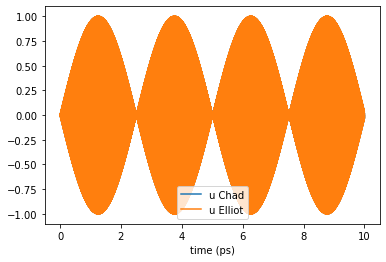

In [39]:
plt.figure()
plt.plot(t_elliot,u,label='u Chad')
plt.plot(t_elliot,u_elliot.real,label='u Elliot')
plt.xlabel('time (ps)')
plt.legend()
plt.show()

/home/moormanc212/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


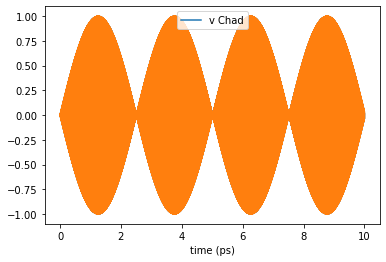

In [40]:
plt.figure()
plt.plot(t_elliot,v,label='v Chad')
#plt.plot(t_elliot,v_elliot.real,label='v Elliot')
plt.plot(t_elliot,v_guess)
plt.xlabel('time (ps)')
plt.legend()
plt.show()

/home/moormanc212/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


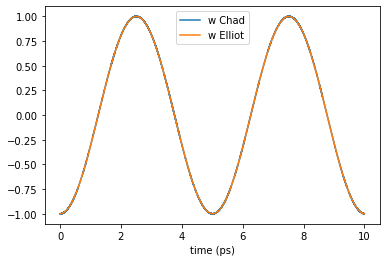

In [41]:
plt.figure()
plt.plot(t_elliot,w,label='w Chad')
plt.plot(t_elliot,w_elliot.real,label='w Elliot')
plt.xlabel('time (ps)')
plt.legend()
plt.show()

In [42]:
w_L2_error = linalg.norm(w - w_elliot)/linalg.norm(w_elliot)
v_L2_error = linalg.norm(v - v_elliot)/linalg.norm(v_elliot)
u_L2_error = linalg.norm(u - u_elliot)/linalg.norm(u_elliot)

In [43]:
U = np.fft.fftshift(np.fft.fft(u))
V = np.fft.fftshift(np.fft.fft(v))
W = np.fft.fftshift(np.fft.fft(w))

U_elliot = np.fft.fftshift(np.fft.fft(u_elliot))
V_elliot = np.fft.fftshift(np.fft.fft(v_elliot))
W_elliot = np.fft.fftshift(np.fft.fft(w_elliot))

frequency = np.fft.fftshift(np.fft.fftfreq(U.size,d=dt))

/home/moormanc212/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


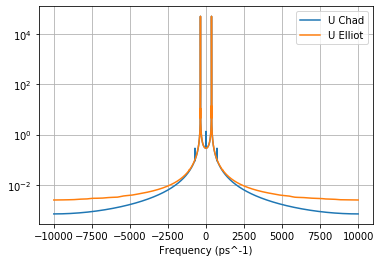

In [44]:
plt.figure()
plt.semilogy(frequency,abs(U), label='U Chad')
plt.semilogy(frequency,abs(U_elliot),label='U Elliot')
plt.xlabel('Frequency (ps^-1)')
plt.legend()
plt.grid()
plt.show()

/home/moormanc212/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


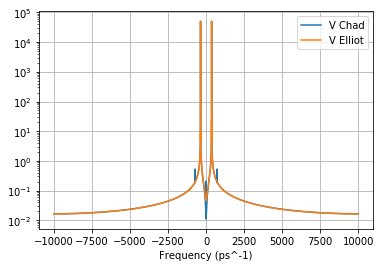

In [45]:
plt.figure()
plt.semilogy(frequency,abs(V), label='V Chad')
plt.semilogy(frequency,abs(V_elliot),label='V Elliot')
plt.xlabel('Frequency (ps^-1)')
plt.legend()
plt.grid()
plt.show()

/home/moormanc212/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


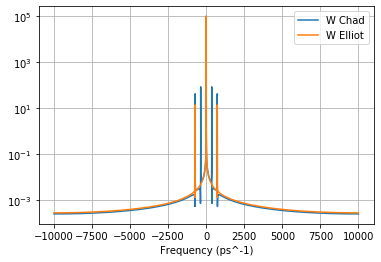

In [46]:
plt.figure()
plt.semilogy(frequency,abs(W), label='W Chad')
plt.semilogy(frequency,abs(W_elliot),label='W Elliot')
plt.xlabel('Frequency (ps^-1)')
plt.legend()
plt.grid()
plt.show()

In [47]:
print('Number of frequencies solved:',num_frequencies)
print('u L2 norm error',u_L2_error)
print('v L2 norm error',v_L2_error)
print('w L2 norm error', w_L2_error)

Number of frequencies solved: 5
u L2 norm error 0.06561871202029854
v L2 norm error 0.06561916795292345
w L2 norm error 0.001092508779345386
